# CNN Inference of Political Affiliation

**Inspiration:** 

### [Facial recognition technology can expose political orientation from naturalistic facial images](https://www.nature.com/articles/s41598-020-79310-1)

Abstract:

> Ubiquitous facial recognition technology can expose individuals’ political orientation, as faces of liberals and conservatives consistently differ. A facial recognition algorithm was applied to naturalistic images of 1,085,795 individuals to predict their political orientation by comparing their similarity to faces of liberal and conservative others. Political orientation was correctly classified in 72% of liberal–conservative face pairs, remarkably better than chance (50%), human accuracy (55%), or one afforded by a 100-item personality questionnaire (66%). Accuracy was similar across countries (the U.S., Canada, and the UK), environments (Facebook and dating websites), and when comparing faces across samples. Accuracy remained high (69%) even when controlling for age, gender, and ethnicity. Given the widespread use of facial recognition, our findings have critical implications for the protection of privacy and civil liberties.


### Our Study

Data scraped from: https://www.congress.gov/members 

LeNet-5 Architecture:

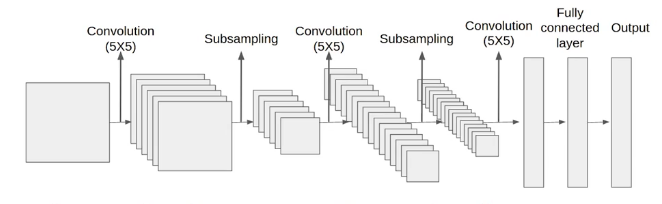

**Things to keep in mind:**

* our dataset sucks (facial differences based on political affiliation are likely small, so you would need a huge dataset to make confident distinction possible!)
* our CNN only ever achieved 60% training accuracy, so classifications will never be very confident
* computational constraints prevent me from creating a larger, more powerful CNN

In [1]:
#import python libraries
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as F 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

classes = {
    1: 'LIBERAL',
    0: 'CONSERVATIVE'
}

In [33]:
#load in trained CNN
class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=True):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6*in_channels, kernel_size=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=14),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=4)
        )

        self.classifier = nn.Sequential(
            nn.Linear(1408*in_channels, 120*in_channels),
            nn.Tanh(),
            nn.Dropout(0.7),
            nn.Linear(120*in_channels, 84*in_channels),
            nn.Tanh(),
            nn.Dropout(0.8),
            nn.Linear(84*in_channels, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    

#initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5(2)
model.eval()
model.load_state_dict(torch.load('../architectures/LeNet5.pth'))

#define inference image transform/pre-processing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((120, 100)),
    transforms.Grayscale(1),
    transforms.ToTensor()
])

#define predict image function
def predict_image(image):
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output[1].data.cpu().numpy().argmax()
    conf = (output[1].data.cpu().numpy().max())
    return index, conf

## Predicting Political Affiliation

Predicted political affiliation: LIBERAL
Confidence level: 51%


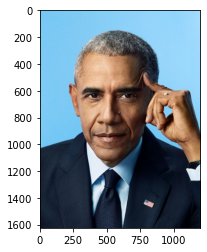

In [39]:
img = mpimg.imread('./photos/obama.jpeg')
#img = mpimg.imread('./photos/trump.jpg')
#img = mpimg.imread('./photos/jonah.jpg')
#img = mpimg.imread('./photos/jonah2.jpg')
#img = mpimg.imread('./photos/parker.jpg')
#img = mpimg.imread('./photos/nate.jpg')
#img = mpimg.imread('./photos/greg.jpg')
#img = mpimg.imread('./photos/bear.jpg')
#img = mpimg.imread('./photos/dog.jpg')
pred = predict_image(img)
plt.imshow(img)
print('Predicted political affiliation:', classes.get(pred[0]))
print('Confidence level:', str(round(pred[1]*100)) + '%')